In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import ast
import re
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import ctc_batch_cost
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [2]:
from google.colab import userdata

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    file.write(userdata.get('kaggle'))

rm: cannot remove '/root/.kaggle': No such file or directory


In [5]:
!kaggle datasets download -d pradeepsiva/mjsynth-1-3-6lakh

Dataset URL: https://www.kaggle.com/datasets/pradeepsiva/mjsynth-1-3-6lakh
License(s): unknown
100% 2.37G/2.37G [01:53<00:00, 23.5MB/s]
100% 2.37G/2.37G [01:53<00:00, 22.4MB/s]


In [6]:
with zipfile.ZipFile('/content/mjsynth-1-3-6lakh.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [7]:
!rm /content/mjsynth-1-3-6lakh.zip

In [8]:
annotations_file = '/content/dataset/imgs1_w/imgs1_w/imgs1_text_recog.csv'
images_dir = '/content/dataset/imgs1_w/imgs1_w/imgs1'

In [9]:
annots = pd.read_csv(annotations_file)
annots.head()

,image_name,utf8string
0,image_50000.png,CONFISCATING
1,image_50001.png,Prosody
2,image_50002.png,gulliver
3,image_50003.png,LITTERERS
4,image_50004.png,Dings


In [10]:
annots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246001 entries, 0 to 246000
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_name  246001 non-null  object
 1   utf8string  245995 non-null  object
dtypes: object(2)
memory usage: 3.8+ MB


In [11]:
img_loc = images_dir+'/'+annots['image_name'][12]
img = cv2.imread(img_loc)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

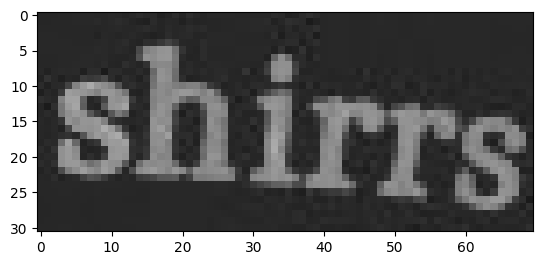

In [12]:
plt.imshow(img)
plt.show()

In [13]:
annots['utf8string'][12]

'shirrs'

In [14]:
def clean_text(text, allowed_characters):
    pattern = f"[^{allowed_characters}]"
    cleaned_text = re.sub(pattern, "", text)
    return cleaned_text

In [15]:
def preprocess_image(img,target_size=(128, 32)):
    if img.size == 0:
          raise ValueError("Empty image encountered during preprocessing.")

    #image = cv2.resize(img, (128, 32))
    image = img.astype(np.float32) / 255.0
    image = cv2.resize(image, target_size)
    image = np.expand_dims(image, axis=-1)

    return image

In [16]:
def one_hot_encode_sequences(sequences, num_classes):
    return [to_categorical(seq, num_classes=num_classes) for seq in sequences]

In [17]:
def text_to_sequence(text, char_to_index):
    return [char_to_index.get(char, unk_index) for char in text]

In [18]:
def padded_sequences(sequences, maxlen, num_classes):
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post', value=unk_index)
    return one_hot_encode_sequences(padded, num_classes)

In [19]:
characters = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

# Create the mapping
char_to_index = {char: idx for idx, char in enumerate(characters)}

# Optionally, add a special token for unknown characters
unk_index = len(characters)
char_to_index['UNK'] = unk_index

# Create reverse mapping
index_to_char = {idx: char for char, idx in char_to_index.items()}

In [20]:
def initialize_model(input_shape, num_classes):
    input_img = layers.Input(shape=input_shape, name='image_input')

    # Convolutional Layers
    x = layers.Conv2D(8, (3, 3), padding='same', activation='relu')(input_img)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)

    # Reshape for RNN
    new_shape = (input_shape[0] // 4, -1)
    x = layers.Reshape(target_shape=new_shape)(x)

    # Recurrent Layers
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)

    # Fully connected layer
    x = layers.Dense(num_classes, activation='softmax')(x)

    # Model
    model = models.Model(inputs=input_img, outputs=x)

    model.summary()
    return model

In [21]:
def ctc_loss_function(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
    input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
    label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

    loss = ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [22]:
input_shape = (32, 128, 1)
max_text_length = 8
num_classes =len(characters)+1

In [23]:
model = initialize_model(input_shape, num_classes)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 32, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 128, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 128, 8)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 128, 16)         │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 64, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 64, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 32, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 32, 32)           │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 32, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 32, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 32, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 16, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 16, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 16, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 16, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 16, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 347,199 (1.32 MB)

 Trainable params: 346,847 (1.32 MB)

 Non-trainable params: 352 (1.38 KB)

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
X, y = [], []
max_images = 100000
count = 0

for idx, row in tqdm(annots.iterrows()):
    if count > max_images:
        break
    image_path = os.path.join(images_dir, f"{row['image_name']}")

    # Read and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    try:
        image = preprocess_image(image)
    except ValueError as e:
        print(e)
        continue  # Skip if preprocessing fails

    # Convert text to sequence and pad
    text = row['utf8string']
    if isinstance(text,float):
        continue
    cleaned_text = clean_text(text, characters)

    if len(cleaned_text) > max_text_length:
        cleaned_text = cleaned_text[:max_text_length]

    text_sequence = text_to_sequence(cleaned_text, char_to_index)
    text_sequence = padded_sequences([text_sequence], maxlen=max_text_length, num_classes=num_classes)
    text_sequence = np.squeeze(text_sequence, axis=0)

    X.append(image)
    y.append(text_sequence)

    count += 1

100003it [01:01, 1638.33it/s]


In [26]:
X,y = np.array(X),np.array(y)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

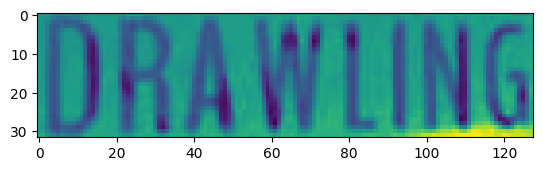

In [28]:
plt.imshow(X_train[4])

In [36]:
for x in y_train[4]:
    print(x)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [37]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.1850 - loss: 3.0625 - val_accuracy: 0.2492 - val_loss: 2.6361
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 75s 19ms/step - accuracy: 0.2879 - loss: 2.4931 - val_accuracy: 0.3666 - val_loss: 2.2158
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.4037 - loss: 2.0613 - val_accuracy: 0.4699 - val_loss: 1.8295
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - accuracy: 0.4913 - loss: 1.7383 - val_accuracy: 0.5264 - val_loss: 1.6218
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.5526 - loss: 1.5210 - val_accuracy: 0.5718 - val_loss: 1.4631
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - accuracy: 0.5975 - loss: 1.3647 - val_accuracy: 0.6046 - val_loss: 1.3509
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.6312 - loss: 1.2478 - val_accuracy: 0.6327 - val_loss: 1.2578
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.6575 -

In [38]:
model.evaluate(X_test, y_test)

626/626 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7210 - loss: 1.0030


[0.994414746761322, 0.7236263155937195]

In [39]:
model.save('crnn_mjsynth_model.keras')

In [40]:
def show_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [33]:
def decode_prediction(prediction):
    decoded_text = []
    for i in range(prediction.shape[1]):
        max_index = np.argmax(prediction[0][i])
        if max_index != unk_index:
            decoded_text.append(index_to_char[max_index])
    return ''.join(decoded_text)

In [34]:
def make_prediction(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = preprocess_image(img)
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    decoded_text = decode_prediction(prediction)

    return decoded_text

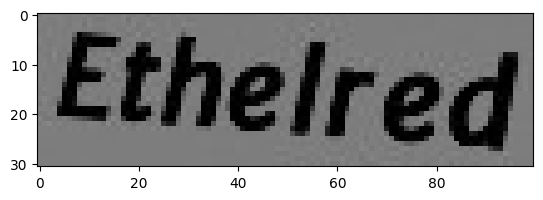

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Text: Ethelred
Actual Text: Ethelred


In [50]:
id = np.random.randint(0,len(annots))
image_path = images_dir+'/'+annots['image_name'][id]
show_image(image_path)
predicted_text = make_prediction(image_path)
print("Predicted Text:", predicted_text)
print("Actual Text:", annots['utf8string'][id])